In [22]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.dates import date2num

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, chi2

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings("ignore")

In [23]:
df_orig = pd.read_csv('data/data.csv', usecols=['datetime', 'machine_status',
                                                'sensor_00', 'sensor_10', 'sensor_20', 'sensor_30',
                                                'sensor_40', 'sensor_50'])

print(type(df_orig['sensor_00'].iloc[0]), type(df_orig['datetime'].iloc[0]))
# Let's convert the data type of timestamp column to datatime format
df_orig['datetime'] = pd.to_datetime(df_orig['datetime'])
print(type(df_orig['sensor_00'].iloc[0]), type(df_orig['datetime'].iloc[0]))

# Selecting subset
cond_1 = df_orig['datetime'] >= '2018-04-12 00:00:00'
cond_2 = df_orig['datetime'] <= '2018-04-19 00:00:00'
df_orig = df_orig[cond_1 & cond_2]
print(df_orig.shape)

<class 'numpy.float64'> <class 'str'>
<class 'numpy.float64'> <class 'pandas._libs.tslibs.timestamps.Timestamp'>
(10080, 8)


In [24]:
df_orig.head()

,sensor_00,sensor_10,sensor_20,sensor_30,sensor_40,sensor_50,machine_status,datetime
0,2.456539,34.59615,373.3553,719.4445,69.01041,238.7153,NORMAL,2018-04-12 00:00:00
1,2.456539,34.59615,373.3553,719.4445,69.01041,238.7153,NORMAL,2018-04-12 00:01:00
2,2.446702,34.89972,373.5880,709.2593,70.57291,239.8727,NORMAL,2018-04-12 00:02:00
3,2.456539,33.96887,374.9091,706.0185,71.61458,241.3194,NORMAL,2018-04-12 00:03:00
4,2.451620,35.09749,374.9961,689.3519,71.35416,241.6088,NORMAL,2018-04-12 00:04:00


## Preprocessing

In [4]:
def drop_duplicates(df: pd.DataFrame(), subset: list = ['DATE_TIME']) -> pd.DataFrame():
    df = df.drop_duplicates((subset))
    return df

In [5]:
def fill_missing_date(df: pd.DataFrame(), column_datetime: str ='DATE_TIME'):
    print(f'Orig shape: {df.shape}')

    data_s = df.drop([column_datetime], axis=1)
    datetime_s = df[column_datetime].astype(str)
    
    start_date = min(df[column_datetime])
    end_date = max(df[column_datetime])
    date_s = pd.date_range(start_date, end_date, freq="min").strftime('%Y-%m-%d %H:%M:%S')
    
    data_processed_s = []
    for date_val in date_s:
        pos = np.where(date_val == datetime_s)[0]        
        assert len(pos) in [0, 1]
        if len(pos) == 0:
            data = [date_val] + [0] * data_s.shape[1]
        elif len(pos) == 1:
            data = [date_val] + data_s.iloc[pos].values.tolist()[0]
        data_processed_s.append(data)
    
    df_processed = pd.DataFrame(data_processed_s, columns=[column_datetime] + data_s.columns.values.tolist())
    df_processed[column_datetime] = pd.to_datetime(df_processed[column_datetime])
    print(f'Output shape: {df_processed.shape}')
    
    return df_processed

In [6]:
df_processed = drop_duplicates(df_orig, subset=['datetime'])
df = fill_missing_date(df_processed, column_datetime='datetime')
df

Orig shape: (10080, 8)
Output shape: (10081, 8)


,datetime,sensor_00,sensor_10,sensor_20,sensor_30,sensor_40,sensor_50,machine_status
0,2018-04-12 00:00:00,2.456539,34.596150,373.3553,719.4445,69.010410,238.715300,NORMAL
1,2018-04-12 00:01:00,2.456539,34.596150,373.3553,719.4445,69.010410,238.715300,NORMAL
2,2018-04-12 00:02:00,2.446702,34.899720,373.5880,709.2593,70.572910,239.872700,NORMAL
3,2018-04-12 00:03:00,2.456539,33.968870,374.9091,706.0185,71.614580,241.319400,NORMAL
4,2018-04-12 00:04:00,2.451620,35.097490,374.9961,689.3519,71.354160,241.608800,NORMAL
...,...,...,...,...,...,...,...,...
10076,2018-04-18 23:56:00,2.372221,0.885417,389.6701,643.9814,29.947916,33.564816,RECOVERING
10077,2018-04-18 23:57:00,2.372221,0.889061,391.0505,651.3889,29.947916,33.564816,RECOVERING
10078,2018-04-18 23:58:00,2.372221,0.885417,389.8206,675.9259,29.947916,33.564816,RECOVERING
10079,2018-04-18 23:59:00,2.372221,0.885417,389.9706,666.6666,29.947916,33.564816,RECOVERING


#### Dividing data

In [7]:
df_data = df.drop(columns=['machine_status'], axis=1)
df_labels = df[['datetime', 'machine_status']].copy()
print(set(df_labels['machine_status']))
df_labels['machine_status'][df_labels['machine_status'] != 'BROKEN'] = 0
df_labels['machine_status'][df_labels['machine_status'] == 'BROKEN'] = 1
print(df_data.shape, df_labels.shape)

{0, 'RECOVERING', 'NORMAL', 'BROKEN'}
(10081, 7) (10081, 2)


In [8]:
set(df_labels['machine_status'])

{0, 1}

## Visualization

Let's visualize the sensor readings across the entire 52 sensors and mark the pump's broken state in red color on the same graph

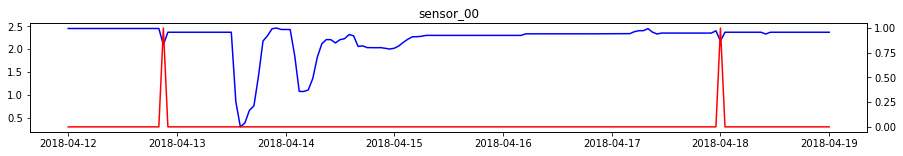

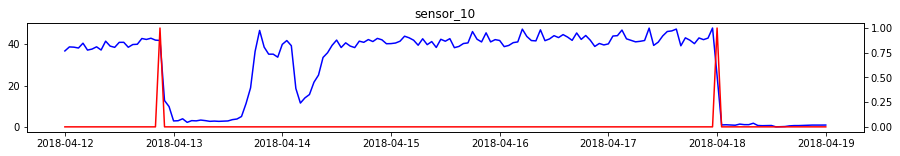

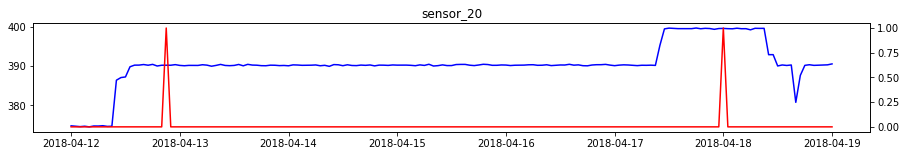

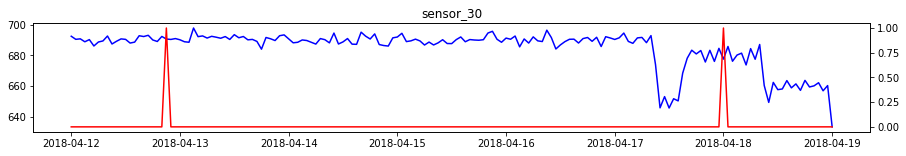

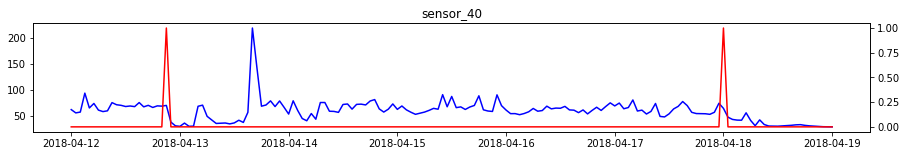

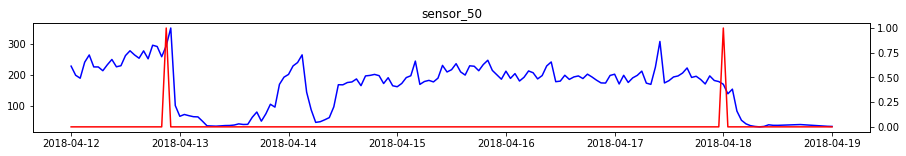

In [9]:
df_data_hour = df_data.groupby(pd.Grouper(key='datetime', axis=0, freq='H')).mean()
df_labels_hour = df_labels.groupby(pd.Grouper(key='datetime', axis=0, freq='H')).sum()
for name in df.columns:
    if name not in ['datetime', 'machine_status']:
        fig, axs = plt.subplots(1, 1, figsize=(15, 2))
        axs.plot(df_data_hour[name], color='blue')
        axs_twinx = axs.twinx()
        axs_twinx.plot(df_labels_hour['machine_status'], color='red')
        axs.set_title(name)
        plt.show()

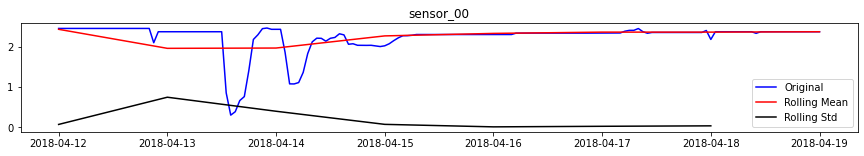

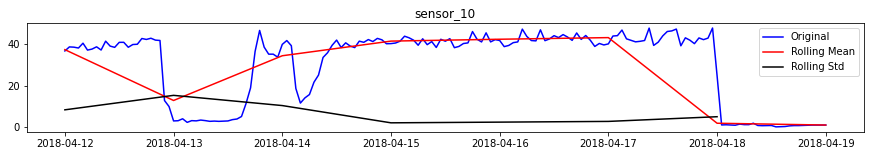

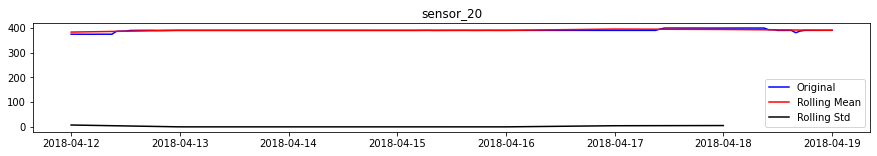

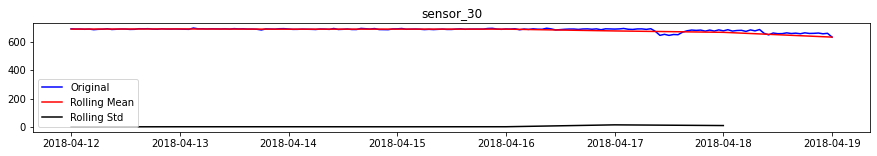

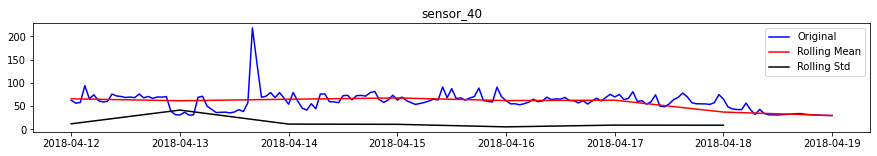

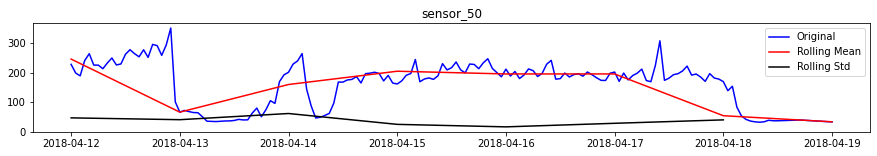

In [10]:
df_data_hour = df_data.groupby(pd.Grouper(key='datetime', axis=0, freq='H')).mean()
df_labels_hour = df_labels.groupby(pd.Grouper(key='datetime', axis=0, freq='H')).sum()

df_rollmean = df_data_hour.resample(rule='D').mean()
df_rollstd = df_data_hour.resample(rule='D').std()

for name in df.columns:
    if name not in ['datetime', 'machine_status']:
        fig, axs = plt.subplots(1, 1, figsize=(15, 2))
        axs.plot(df_data_hour[name], color='blue', label='Original')
        axs.plot(df_rollmean[name], color='red', label='Rolling Mean')
        plt.plot(df_rollstd[name], color='black', label='Rolling Std' )
        axs.set_title(name)
        plt.legend()
        plt.show()

#### Boxplot

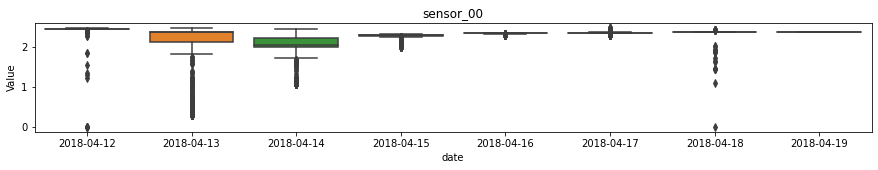

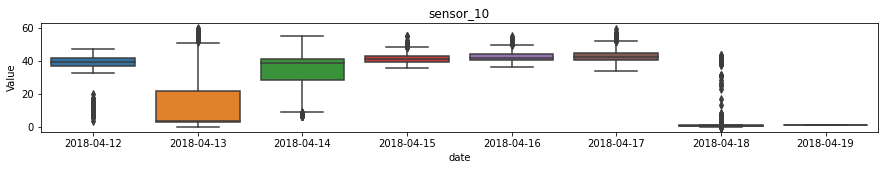

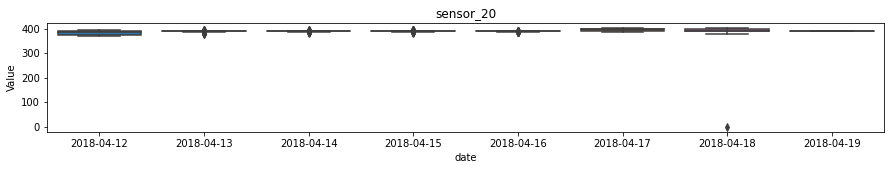

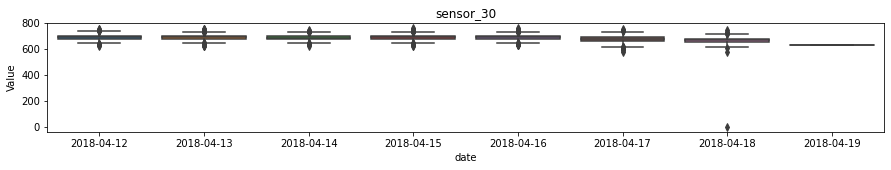

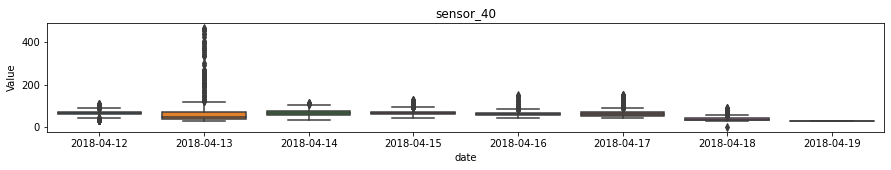

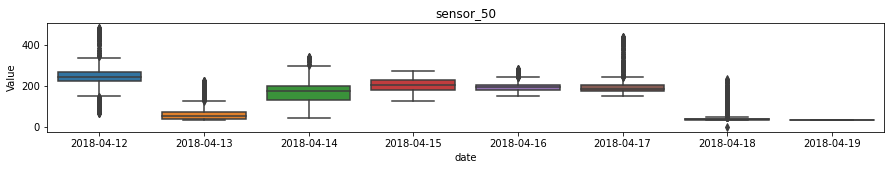

In [11]:
df_boxplot = df_data.copy()
df_boxplot['date'] = df_boxplot['datetime'].dt.strftime('%Y-%m-%d')
for name in df_boxplot.columns:
    if name not in ['datetime', 'date']:
        fig, axs = plt.subplots(1, 1, figsize=(15, 2))
        sns.boxplot(y=name, x='date', data=df_boxplot)
        axs.set_ylabel('Value')
        axs.set_title(name)
        plt.show()

#### Fourier

In [12]:
def fft(data, nwindow=64, freq = 32):
    ffts = []
    for i in range(0, len(data)-nwindow, nwindow//2):
        sliced = data[i:i+nwindow]
        fft = np.abs(np.fft.rfft(sliced*np.hamming(nwindow))[:freq])
        ffts.append(fft.tolist())
    ffts = np.array(ffts)
    return ffts


def data_plot(date_time, data, labels, ax):
    ax.plot(date_time, data)
    ax.set_xlim(date2num(np.min(date_time)), date2num(np.max(date_time)))
    axs_twinx = ax.twinx()
    axs_twinx.plot(date_time, labels, color='red')
    ax.set_ylabel('Label')


def fft_plot(ffts, ax):
    ax.imshow(np.flipud(np.rot90(ffts)), aspect='auto', cmap=matplotlib.cm.bwr, 
               norm=LogNorm(vmin=np.min(ffts), vmax=np.max(ffts)))
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Freq')

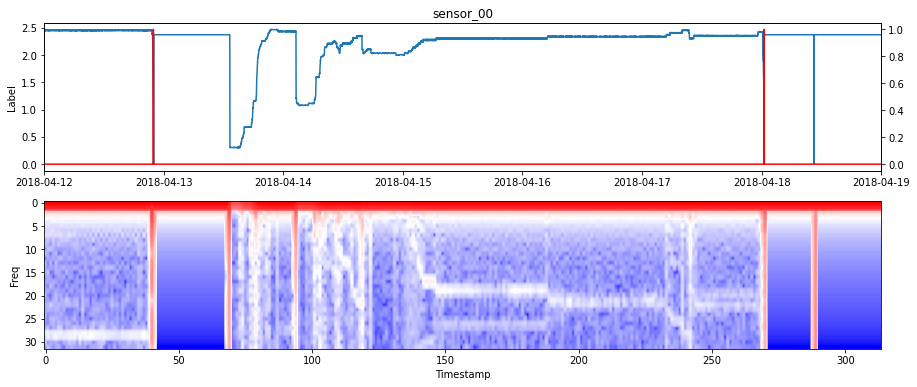

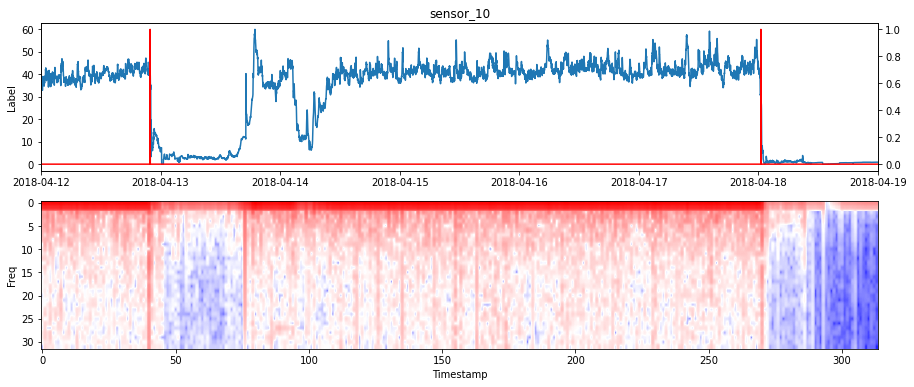

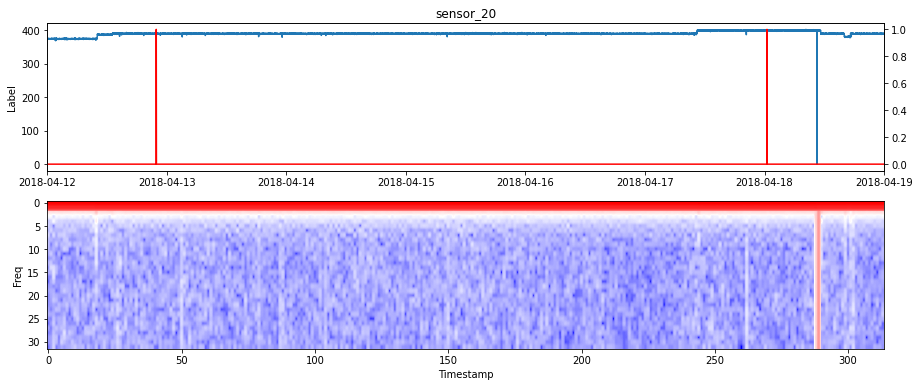

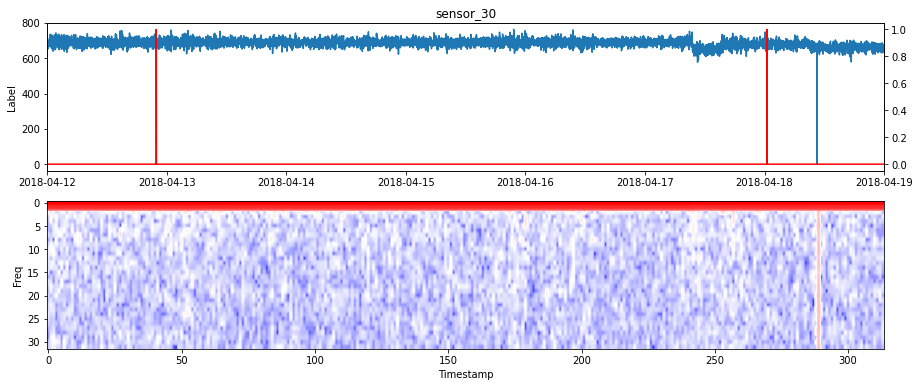

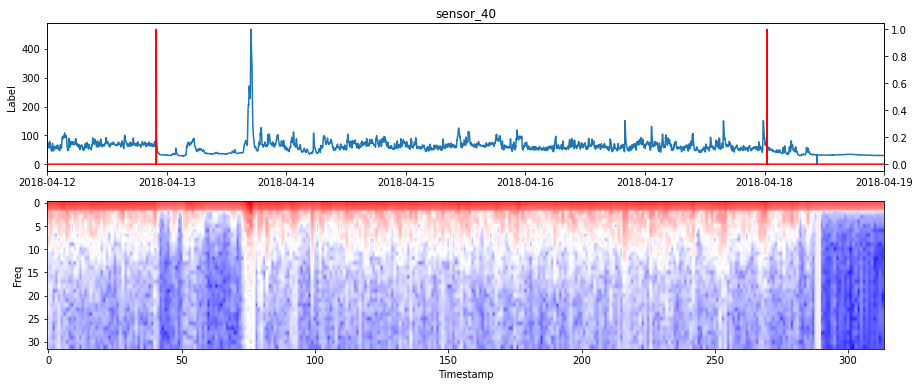

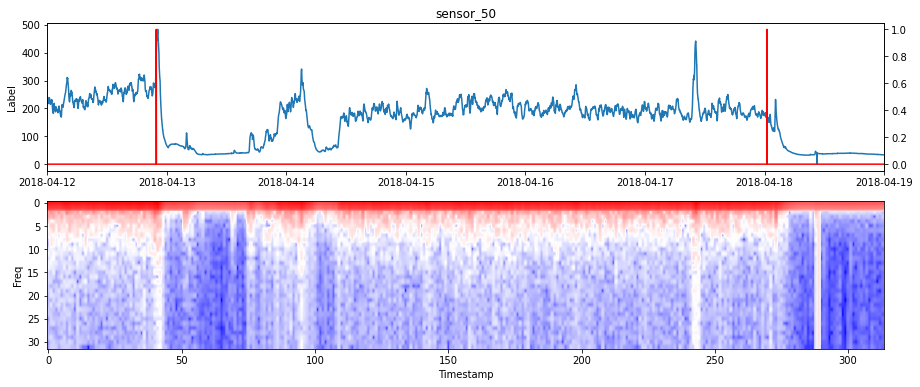

In [13]:
df_fourier = df_data.copy()
for name in df_boxplot.columns:
    if name not in ['datetime', 'date']:
        fig, axs = plt.subplots(2, 1, figsize=(15, 6))
        data = df_fourier[name].to_numpy()
        ffts = fft(data, nwindow=64, freq = 32)
        data_plot(df_fourier['datetime'], data, df_labels['machine_status'], axs[0])
        fft_plot(ffts, axs[1])
        axs[0].set_title(name)
        plt.show()

#### Entropy

In [14]:
def entropy(data, nwindow=64, freq = 32):
    entropy_s = []
    for i in range(0, len(data)-nwindow, nwindow//2):
        sliced = data[i:i+nwindow]
        fft = np.abs(np.fft.rfft(sliced*np.hamming(nwindow))[:nwindow//2])
        p = fft / np.sum(fft)
        entropy = - np.sum(p * np.log(p))
        entropy_s.append(entropy)
    entropy_s = np.array(entropy_s)
    return entropy_s


def data_plot(date_time, data, labels, ax):
    ax.plot(date_time, data)
    axs_twinx = ax.twinx()
    axs_twinx.plot(date_time, labels, color='red')
    ax.set_xlabel('Value')
    ax.set_ylabel('Label')


def entropy_plot(data, ax):
    ax.plot(data, c='k')
    ax.set_xlabel('Timestamp')
    ax.set_ylabel('Entropy')

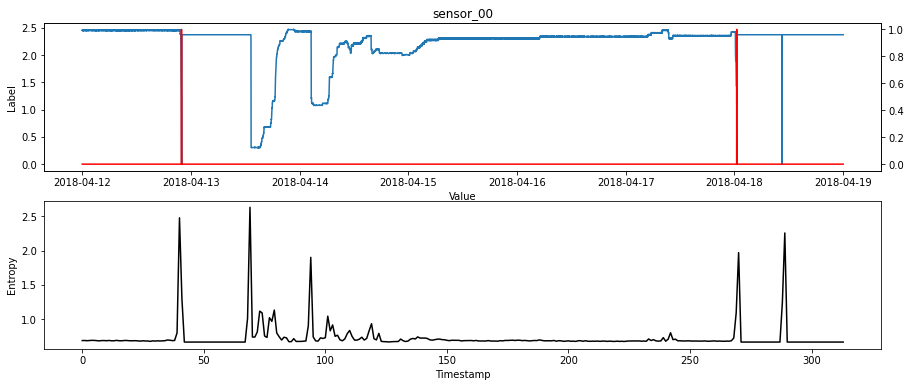

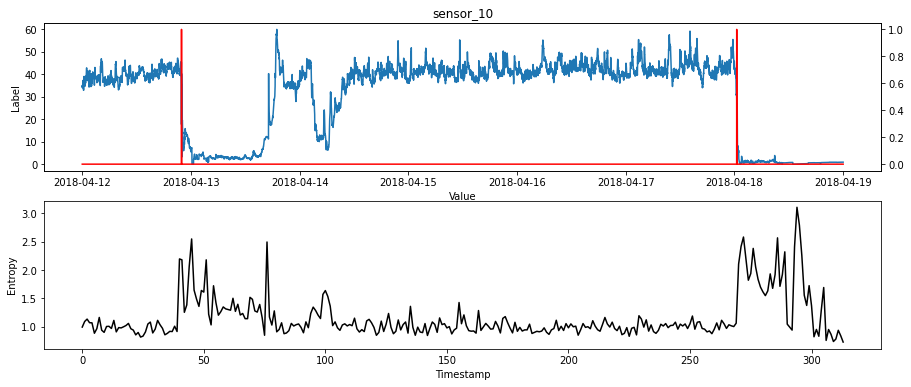

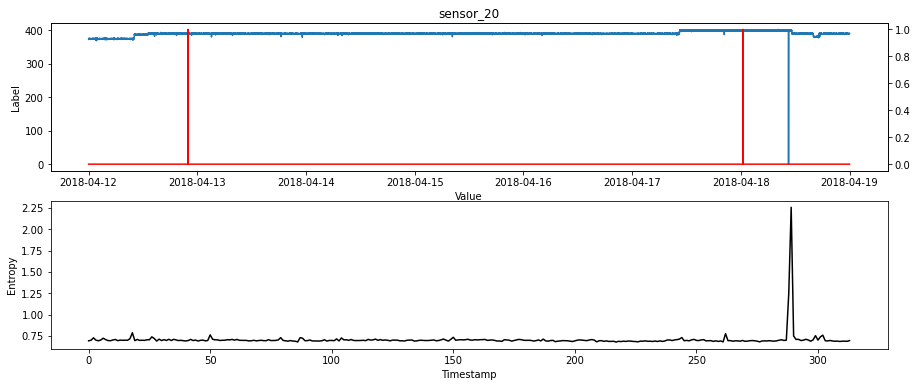

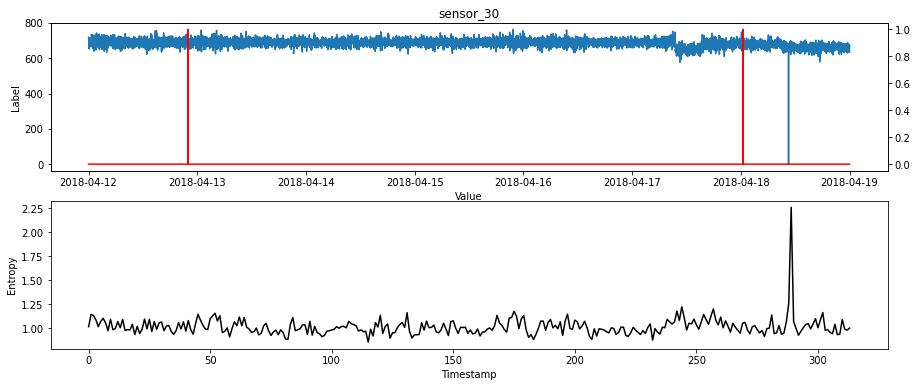

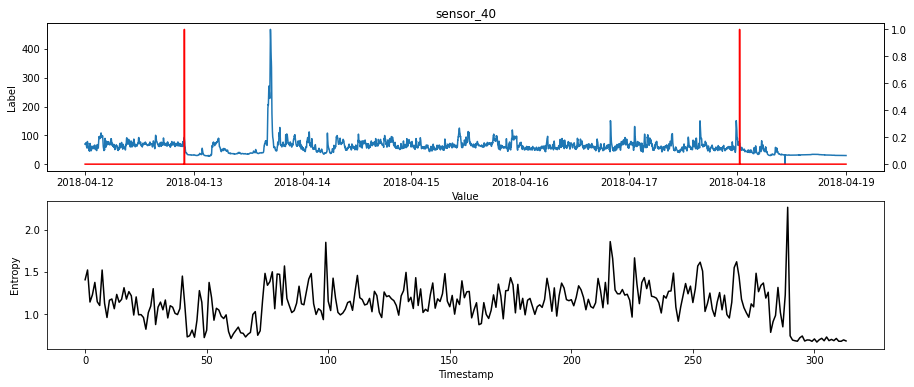

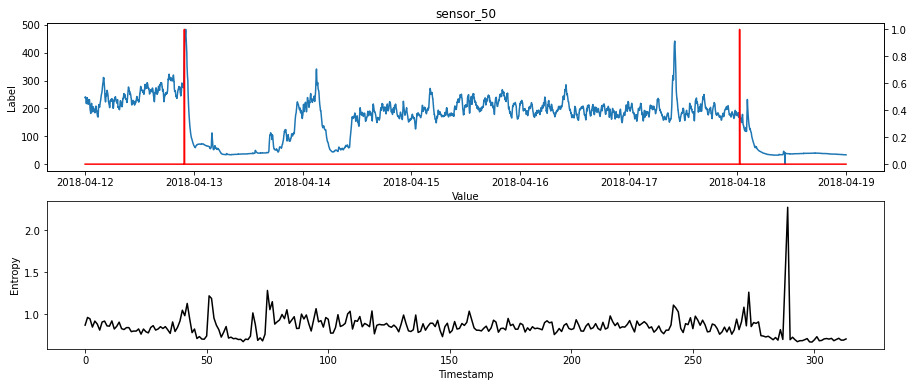

In [15]:
df_entropy = df_data.copy()
for name in df_boxplot.columns:
    if name not in ['datetime', 'date']:
        fig, axs = plt.subplots(2, 1, figsize=(15, 6))
        data = df_entropy[name].to_numpy()
        entropy_s = entropy(data, nwindow=64, freq = 32)
        data_plot(df_entropy['datetime'], data, df_labels['machine_status'], axs[0])
        entropy_plot(entropy_s, axs[1])
        axs[0].set_title(name)
        plt.show()

#### Check stationarity with Dickey-Fuller Test

In [16]:
x = df_data[df_data.columns].drop(columns=['datetime'])
scaler = StandardScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(x)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA())])

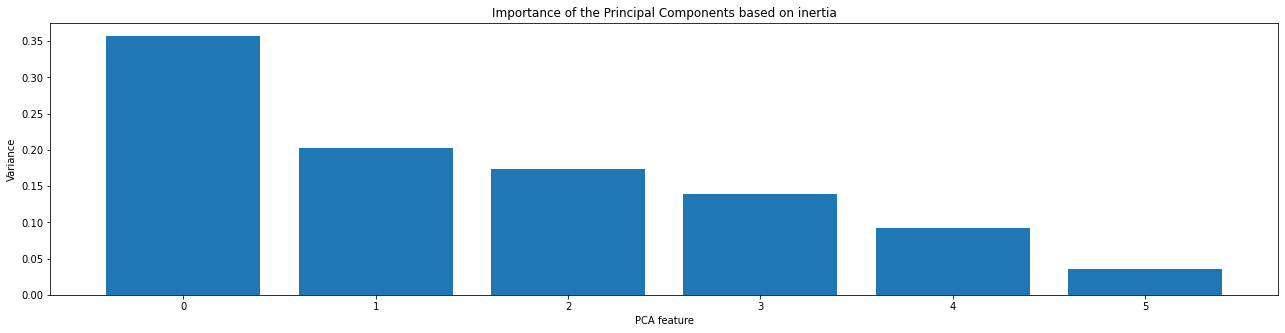

In [17]:
features = range(pca.n_components_)
plt.figure(figsize=(22, 5))
plt.bar(features, pca.explained_variance_ratio_)
plt.xlabel('PCA feature')
plt.ylabel('Variance')
plt.xticks(features)
plt.title("Importance of the Principal Components based on inertia")
plt.show()

In [18]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['pc1', 'pc2'])

df_pca = df_data.copy()
df_pca['pca1'] = pd.Series(principalDf['pc1'].values, index=df.index)
df_pca['pca2'] = pd.Series(principalDf['pc2'].values, index=df.index)
print(df_pca.shape)
print(df_pca.head())

(10081, 9)
             datetime  sensor_00  sensor_10  sensor_20  sensor_30  sensor_40  \
0 2018-04-12 00:00:00   2.456539   34.59615   373.3553   719.4445   69.01041   
1 2018-04-12 00:01:00   2.456539   34.59615   373.3553   719.4445   69.01041   
2 2018-04-12 00:02:00   2.446702   34.89972   373.5880   709.2593   70.57291   
3 2018-04-12 00:03:00   2.456539   33.96887   374.9091   706.0185   71.61458   
4 2018-04-12 00:04:00   2.451620   35.09749   374.9961   689.3519   71.35416   

   sensor_50       pca1      pca2  
0   238.7153  80.227749  8.401156  
1   238.7153  80.227749  8.401156  
2   239.8727  81.110000  6.585558  
3   241.3194  82.313166  6.249271  
4   241.6088  81.997809  0.940057  


In [19]:
for name in df_pca.columns:
    if name not in ['datetime', 'date']:
        print(f'{name}: ', adfuller(df_pca[name]))

sensor_00:  (-4.288982026391745, 0.00046413778677505943, 13, 10067, {'1%': -3.4309997435394877, '5%': -2.861827148204747, '10%': -2.5669228438492597}, -31804.0714734676)
sensor_10:  (-2.221933316576291, 0.19838144551185893, 12, 10068, {'1%': -3.4309996789875097, '5%': -2.861827119679712, '10%': -2.5669228286653536}, 27766.511868448022)
sensor_20:  (-3.592564245109739, 0.0059047849892509, 37, 10043, {'1%': -3.4310012966444754, '5%': -2.8618278345100223, '10%': -2.566923209170298}, 57403.646550974)
sensor_30:  (-4.647724174292243, 0.00010538788279015939, 39, 10041, {'1%': -3.4310014264051087, '5%': -2.861827891850243, '10%': -2.566923239692562}, 86925.92362313878)
sensor_40:  (-10.29474568760144, 3.494931297495308e-18, 4, 10076, {'1%': -3.430999163033074, '5%': -2.8618268916832887, '10%': -2.566922707302626}, 40904.2633950389)
sensor_50:  (-3.896834428400123, 0.00205826787914369, 5, 10075, {'1%': -3.430999227482557, '5%': -2.8618269201630375, '10%': -2.566922722462425}, 38661.12678622437

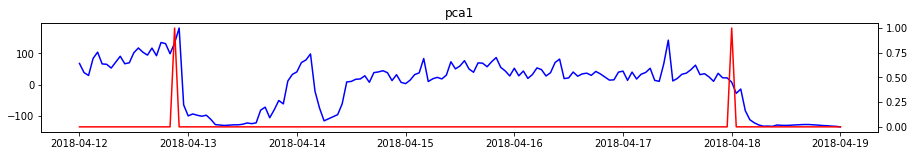

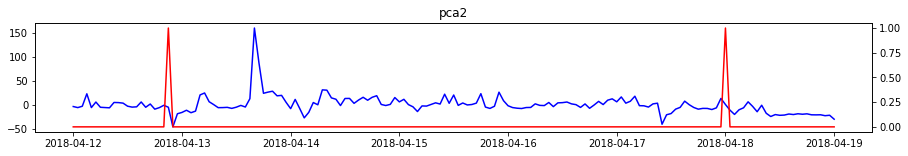

In [20]:
df_pca_hour = df_pca.groupby(pd.Grouper(key='datetime', axis=0, freq='H')).mean()
df_labels_hour = df_labels.groupby(pd.Grouper(key='datetime', axis=0, freq='H')).sum()
for name in df_pca.columns:
    if name in ['pca1', 'pca2']:
        fig, axs = plt.subplots(1, 1, figsize=(15, 2))
        axs.plot(df_pca_hour[name], color='blue')
        axs_twinx = axs.twinx()
        axs_twinx.plot(df_labels_hour['machine_status'], color='red')
        axs.set_title(name)
        plt.show()

#### Check for autocorrelation

Autocorrelation is:  0.024363541344980266


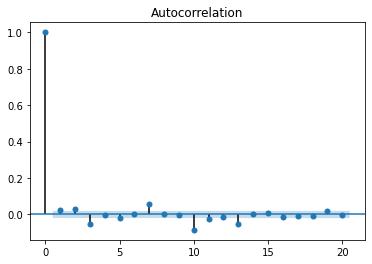

In [21]:
pca1 = principalDf['pc1'].pct_change()
autocorrelation = pca1.dropna().autocorr()
print('Autocorrelation is: ', autocorrelation)
plot_acf(pca1.dropna(), lags=20, alpha=0.05)
plt.show()